# HW 4: a) Models fit to text data and b) Neural Networks
***Name:*** Shreyans Kothari | ***UNI:*** sk4819

In [1]:
from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as ply
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shreyanskothari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Part 1: Build a classification model using text data

In [3]:
import aimodelshare as ai
X_train, X_test, y_train_labels, y_test_labels, example_data, lstm_model, lstm_model2 = ai.import_quickstart_data("clickbait")


Data downloaded successfully.

Preparing downloaded files for use...

Success! Your Quick Start materials have been downloaded. 
You are now ready to run the tutorial.


In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train_labels.shape)
print(y_test_labels.shape)

(24979,)
(6245,)
(24979,)
(6245,)


In [5]:
# function to clean text
def clean_text(txt_in):
    import re
    clean = re.sub('[^A-Za-z0-9]+', " ", txt_in).lower().strip()
    return clean

In [6]:
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [7]:
print("X_train:\n{}".format(X_train.head()))
print("\n")
print("X_train Cleaned:\n{}".format(X_train_clean.head()))

X_train:
0       MyBook Disk Drive Handles Lots of Easy Backups
1                       CIT Posts Eighth Loss in a Row
2    Candy Carson Singing The "National Anthem" Is ...
3    Why You Need To Stop What You're Doing And Dat...
4    27 Times Adele Proved She's Actually The Reale...
Name: headline, dtype: object


X_train Cleaned:
0       mybook disk drive handles lots of easy backups
1                       cit posts eighth loss in a row
2    candy carson singing the national anthem is th...
3    why you need to stop what you re doing and dat...
4    27 times adele proved she s actually the reale...
Name: headline, dtype: object


In [8]:
print("X_test:\n{}".format(X_test.head()))
print("\n")
print("X_test Cleaned:\n{}".format(X_test_clean.head()))

X_test:
0    Buffalo, New York plane crash may have resulte...
1           Under New Chief, Another Shake-Up at Yahoo
2     Warning Sounded as France Moves Ahead on Reactor
3    People limited to 150 friends, despite Faceboo...
4    These Kids Turned Their Bratz Dolls Into Rey F...
Name: headline, dtype: object


X_test Cleaned:
0    buffalo new york plane crash may have resulted...
1            under new chief another shake up at yahoo
2     warning sounded as france moves ahead on reactor
3    people limited to 150 friends despite facebook...
4    these kids turned their bratz dolls into rey f...
Name: headline, dtype: object


In [9]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                   len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


### Model 1: As-is
Before running model 1, I cleaned the text, converted all the letters to lowercase, removed stopwords, and then vectorized it using the count_vectorizer from scikit-learn. 

In [10]:
# Creating preprocessor function and removing stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vec = vectorizer.fit(X_train_clean)

def preprocessor(text_data):
    data_vec = vec.transform(text_data).todense()
    return data_vec

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [12]:
model = LogisticRegression(penalty= 'l2', max_iter = 10000)
model.fit(preprocessor(X_train_clean), y_train_labels)
print("Model 1 Test set score: {}".format(model.score(preprocessor(X_test_clean), y_test_labels)))
print("Model 1 Coefficients: {}".format(model.coef_))

Model 1 Test set score: 0.9521216973578863
Model 1 Coefficients: [[ 1.41036954 -0.82131193  0.6593195  ... -0.37678618  0.43026153
   0.27504466]]


In [13]:
y_pred = model.predict(preprocessor(X_test_clean))
print("Model 1 f1 test set Score: {}".format(f1_score(y_test_labels, y_pred, average='weighted')))

Model 1 f1 test set Score: 0.9521036127000991


In [14]:
print("Model 1 Cross Validation Score: {}".format(
np.mean(cross_val_score(LogisticRegression(penalty = 'l2'), preprocessor(X_train_clean), y_train_labels, scoring = "f1_weighted", cv = 10))))

Model 1 Cross Validation Score: 0.951056653076676


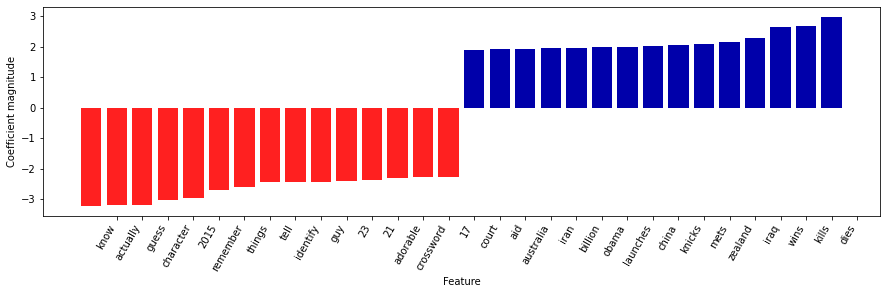

In [15]:
coef = model.coef_
features = vec.get_feature_names()
visualize_coefficients(coef, features, n_top_features=15)

***Conclusion:*** In Model 1, I ran the model on a cleaned text file by removing the stopwords and vectorizing it using the count_vectorizer function. 
- The resulting f1 test set score is: `0.9521036127000991`
- The resulting cross validation f1 score is: `0.951056653076676`

The helper function allows us to visualize the top 15 positive & negative coefficients for Model 1. The top most positive coefficient is `dies` and the most negative coefficient is `know`. 

### Model 2: Stemming
In Model 2, I will conduct stemming on the cleaned text before running a logistic regression model.

In [16]:
def stem_fun(var):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    tmp_txt = [stemmer.stem(word) for word in var.split()]
    tmp_txt = ' '.join(tmp_txt)
    return tmp_txt

In [17]:
X_train_stem = X_train_clean.apply(stem_fun)
X_test_stem = X_test_clean.apply(stem_fun)

In [18]:
print("X_train Cleaned:\n{}".format(X_train_clean.head()))
print("\n")
print("X_train Stemmed:\n{}".format(X_train_stem.head()))

X_train Cleaned:
0       mybook disk drive handles lots of easy backups
1                       cit posts eighth loss in a row
2    candy carson singing the national anthem is th...
3    why you need to stop what you re doing and dat...
4    27 times adele proved she s actually the reale...
Name: headline, dtype: object


X_train Stemmed:
0           mybook disk drive handl lot of easi backup
1                        cit post eighth loss in a row
2    candi carson sing the nation anthem is the onl...
3    whi you need to stop what you re do and date a...
4    27 time adel prove she s actual the realest ce...
Name: headline, dtype: object


In [19]:
print("X_test cleaned:\n{}".format(X_test_clean.head()))
print("\n")
print("X_test stemmed:\n{}".format(X_test_stem.head()))

X_test cleaned:
0    buffalo new york plane crash may have resulted...
1            under new chief another shake up at yahoo
2     warning sounded as france moves ahead on reactor
3    people limited to 150 friends despite facebook...
4    these kids turned their bratz dolls into rey f...
Name: headline, dtype: object


X_test stemmed:
0    buffalo new york plane crash may have result f...
1              under new chief anoth shake up at yahoo
2            warn sound as franc move ahead on reactor
3    peopl limit to 150 friend despit facebook say ...
4    these kid turn their bratz doll into rey from ...
Name: headline, dtype: object


In [20]:
#Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vec_stem = vectorizer.fit(X_train_stem)

def preprocessor(text_data):
    data_vec = vec_stem.transform(text_data).todense()
    return data_vec

In [21]:
model_stem = LogisticRegression(penalty= 'l2', max_iter = 10000)
model_stem.fit(preprocessor(X_train_stem), y_train_labels)
print("Model 2 Test set score: {}".format(model_stem.score(preprocessor(X_test_stem), y_test_labels)))
print("Model 2 Coefficients: {}".format(model_stem.coef_))

Model 2 Test set score: 0.955964771817454
Model 2 Coefficients: [[-0.82009439  1.50852518  0.68081559 ... -0.491362    0.33770607
   0.14474656]]


In [22]:
y_pred = model_stem.predict(preprocessor(X_test_stem))
print("Model 2 f1 test set Score: {}".format(f1_score(y_test_labels, y_pred, average='weighted')))

Model 2 f1 test set Score: 0.9559515901503922


In [23]:
print("Model 2 Cross Validation Score: {}".format(
np.mean(cross_val_score(LogisticRegression(penalty = 'l2'), preprocessor(X_train_stem), y_train_labels, scoring = "f1_weighted", cv = 10))))

Model 2 Cross Validation Score: 0.9511781710619032


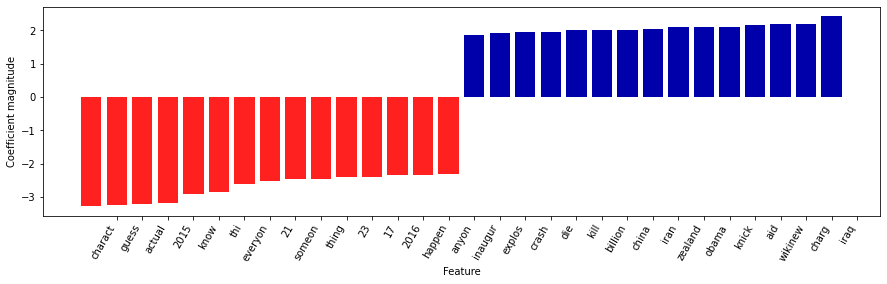

In [24]:
coef = model_stem.coef_
features = vec_stem.get_feature_names()
visualize_coefficients(coef, features, n_top_features=15)

***Conclusion***: In Model 2, I ran the model on a cleaned text file by removing the stopwords, stemmed the words, and then vectorized it using the count_vectorizer function.

- The resulting f1 test set score is: `0.9559515901503922`
- The resulting cross validation f1 score is: `0.9511781710619032`

The top positive & negative coefficients for Model 2 are slightly different from those in Model 1- Model 2 contains a lot of the similar coefficients from Model 1, but stemmed, and then some. The top most positive coefficient is `iraq` and the negative most is `charact`, a stemmed version of character.

### Model 3: Lemmatizing
In addition to cleaning and removing stop words, I lemmatize the text before running the logistic regression model.

In [25]:
def lem_fun(var):
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tmp_txt = [lemmatizer.lemmatize(word) for word in var.split()]
    tmp_txt = ' '.join(tmp_txt)
    return tmp_txt

In [26]:
X_train_lem = X_train_clean.apply(lem_fun)
X_test_lem = X_test_clean.apply(lem_fun)

In [27]:
print("X_train Cleaned:\n{}".format(X_train_clean.head()))
print("\n")
print("X_train Lemmaztized:\n{}".format(X_train_lem.head()))

X_train Cleaned:
0       mybook disk drive handles lots of easy backups
1                       cit posts eighth loss in a row
2    candy carson singing the national anthem is th...
3    why you need to stop what you re doing and dat...
4    27 times adele proved she s actually the reale...
Name: headline, dtype: object


X_train Lemmaztized:
0          mybook disk drive handle lot of easy backup
1                        cit post eighth loss in a row
2    candy carson singing the national anthem is th...
3    why you need to stop what you re doing and dat...
4    27 time adele proved she s actually the reales...
Name: headline, dtype: object


In [28]:
print("X_test Cleaned:\n{}".format(X_test_clean.head()))
print("\n")
print("X_test Lemmatized:\n{}".format(X_test_lem.head()))

X_test Cleaned:
0    buffalo new york plane crash may have resulted...
1            under new chief another shake up at yahoo
2     warning sounded as france moves ahead on reactor
3    people limited to 150 friends despite facebook...
4    these kids turned their bratz dolls into rey f...
Name: headline, dtype: object


X_test Lemmatized:
0    buffalo new york plane crash may have resulted...
1            under new chief another shake up at yahoo
2       warning sounded a france move ahead on reactor
3    people limited to 150 friend despite facebook ...
4    these kid turned their bratz doll into rey fro...
Name: headline, dtype: object


In [29]:
#Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vec_lem = vectorizer.fit(X_train_lem)

def preprocessor(text_data):
    data_vec = vec_lem.transform(text_data).todense()
    return data_vec

In [30]:
model_lem = LogisticRegression(penalty= 'l2', max_iter = 10000)
model_lem.fit(preprocessor(X_train_lem), y_train_labels)
print("Model 3 Test set score: {}".format(model_lem.score(preprocessor(X_test_lem), y_test_labels)))
print("Model 3 Coefficients: {}".format(model_lem.coef_))

Model 3 Test set score: 0.9535628502802241
Model 3 Coefficients: [[ 1.3048573  -0.78244674  0.4469505  ... -0.51717793  0.27192133
   0.30171523]]


In [31]:
y_pred = model_lem.predict(preprocessor(X_test_lem))
print("Model 3 f1 test set Score: {}".format(f1_score(y_test_labels, y_pred, average='weighted')))

Model 3 f1 test set Score: 0.9535456847213106


In [32]:
print("Model 3 Cross Validation Score: {}".format(
np.mean(cross_val_score(LogisticRegression(penalty = 'l2'), preprocessor(X_train_lem), y_train_labels, scoring = "f1_weighted", cv = 10))))

Model 3 Cross Validation Score: 0.9494167310017024


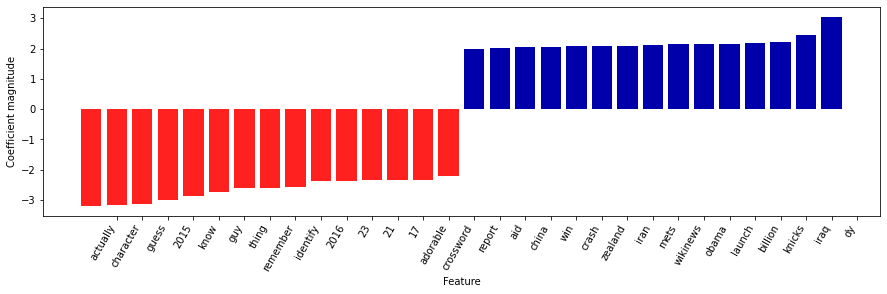

In [33]:
coef = model_lem.coef_
features = vec_lem.get_feature_names()
visualize_coefficients(coef, features, n_top_features=15)

***Conclusion:*** In Model 3, I ran the model on a cleaned text file by removing the stopwords, lemmatized the words, and then vectorized it using the count_vectorizer function.

- The resulting f1 test set score is: `0.9535456847213106`
- The resulting cross validation f1 score is: `0.9494167310017024`

The top positive & negative coefficients for Model 3 are, again, slightly different from those in Model 1 and Model 2. The top most positive coefficient is `dy` and the negative most is `actually`.

### Conclusion:
I ran logistic regression on three different models. The models differ in how the text is preprocessed before I train it using logistic regression. In Model 1, I don't do any additional preprocessing after cleaning the text and removing the stopwords. In Model 2, I take the clean text, remove the stop words, and also stemmatize the words. In Model 3, I lemmatize the text after cleaning it and removing stopwords. The biggest difference between stemming and lemmatizing is that stemming often leads to incorrect meanings and spellings, whereas lemmatizing uses the 'base form', or lemmas, of the words. 

All three models got a very high f1 test set score:
- Model 1 (As-is): `0.9521036127000991`
- Model 2 (Stemmed): `0.9559515901503922`
- Model 3 (Lemmatized): `0.9535456847213106`

Similarly, all three models also had high cross validation score on the training set:
- Model 1 (As-is): `0.951056653076676`
- Model 2 (Stemmed): `0.9511781710619032`
- Model 3 (Lemmatized): `0.9494167310017024`

As we can see from both the f1 score on the test set and the cross validation (f1_weighted) score on the training set, model 2 has performed the best out of the three models.

Thus, for this data, I would choose to use Model 2, aka stemming, over not doing anything or lemmatization.

***Model 2 (stemmed) is the best model.***

___
## Part 2: Build a predictive neural network using Keras
Run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface. 

Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.

In [34]:
iris = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv", sep = ',')

In [35]:
iris.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [36]:
iris = iris.iloc[:,1:]

In [37]:
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [38]:
y = iris['Species']
X = iris.loc[:, iris.columns != 'Species']

In [39]:
display(iris.head())
display(X.head())
display(y[0::10])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


0          setosa
10         setosa
20         setosa
30         setosa
40         setosa
50     versicolor
60     versicolor
70     versicolor
80     versicolor
90     versicolor
100     virginica
110     virginica
120     virginica
130     virginica
140     virginica
Name: Species, dtype: object

In [40]:
y = pd.get_dummies(y)
y

,setosa,versicolor,virginica
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
145,0,0,1
146,0,0,1
147,0,0,1
148,0,0,1


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 4)
(38, 4)
(112, 3)
(38, 3)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras as keras

In [44]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim = 4))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [45]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=32)
score = model.evaluate(X_test, y_test, batch_size=32) # extract loss and accuracy from test data evaluation
print(score)

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 1.1000 - accuracy: 0.3661
Epoch 2/200
4/4 [==============================] - 0s 3ms/step - loss: 0.9823 - accuracy: 0.3661
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.8861 - accuracy: 0.4286
Epoch 4/200
4/4 [==============================] - 0s 3ms/step - loss: 0.8143 - accuracy: 0.6964
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.7674 - accuracy: 0.6964
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.7375 - accuracy: 0.6964
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.7155 - accuracy: 0.6964
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.6964
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6964
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6964
Epoch 11/200
4/4 [===========

4/4 [==============================] - 0s 32ms/step - loss: 0.3151 - accuracy: 0.9375
Epoch 85/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3150 - accuracy: 0.9554
Epoch 86/200
4/4 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3126 - accuracy: 0.9196
Epoch 87/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3106 - accuracy: 0.9375
Epoch 88/200
4/4 [==============================] - 0s 4ms/step - loss: 0.3068 - accuracy: 0.9286
Epoch 89/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3041 - accuracy: 0.9643
Epoch 90/200
4/4 [==============================] - 0s 5ms/step - loss: 0.2988 - accuracy: 0.9375
Epoch 91/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2952 - accuracy: 0.9643
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.9464
Epoch 93/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2982 - accurac

4/4 [==============================] - 0s 2ms/step - loss: 0.1599 - accuracy: 0.9732
Epoch 167/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1462 - accuracy: 0.9732
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1514 - accuracy: 0.9732
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9732
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1459 - accuracy: 0.9821
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9821
Epoch 172/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9732
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9643
Epoch 174/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.9732
Epoch 175/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9643
Epoch 176/200
4/4 [=====

In [46]:
score = model.evaluate(X_test, y_test, batch_size = 32)

2/2 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9474


In [47]:
print("The model gives a loss of", score[0], "and test set accuracy score", score[1])

The model gives a loss of 0.19559599459171295 and test set accuracy score 0.9473684430122375


In [48]:
ypreds = model.predict(X_test)
print(ypreds) #gives prediction of each category, largest is selected for predict_classes()
ypreds_classindex = np.argmax(model.predict(X_test), axis=-1)
print(ypreds_classindex) 


[[2.11190650e-06 1.94937438e-02 9.80504155e-01]
 [9.06884018e-03 9.19021249e-01 7.19099566e-02]
 [9.93955910e-01 6.04404043e-03 1.04344281e-07]
 [1.33307606e-06 3.45640779e-02 9.65434611e-01]
 [9.87723470e-01 1.22756641e-02 8.40709220e-07]
 [1.18259862e-07 6.07643882e-03 9.93923485e-01]
 [9.89172816e-01 1.08266203e-02 6.40318547e-07]
 [2.52096402e-03 9.02636170e-01 9.48428288e-02]
 [1.84463395e-03 8.49526763e-01 1.48628578e-01]
 [1.10821370e-02 9.50653553e-01 3.82643342e-02]
 [4.36358641e-06 3.91096994e-02 9.60885882e-01]
 [3.56104528e-03 9.20518935e-01 7.59200752e-02]
 [1.36181701e-03 7.23803818e-01 2.74834424e-01]
 [2.04541208e-03 8.22797477e-01 1.75157189e-01]
 [1.04714721e-03 6.67425573e-01 3.31527293e-01]
 [9.88545477e-01 1.14538465e-02 7.04931551e-07]
 [1.56911113e-03 7.22871661e-01 2.75559217e-01]
 [1.19764986e-03 5.67803979e-01 4.30998355e-01]
 [9.84032571e-01 1.59654636e-02 1.93663550e-06]
 [9.92866039e-01 7.13367946e-03 1.83983232e-07]
 [1.41562505e-05 5.69559336e-02 9.430299

In [49]:
#Getting predictions:
labels = ["setosa", "versicolor", "virginica"]
y_pred = []
for object in ypreds_classindex:
    y_pred.append((labels[object]))

In [50]:
#Prediction values
y_pred

['virginica',
 'versicolor',
 'setosa',
 'virginica',
 'setosa',
 'virginica',
 'setosa',
 'versicolor',
 'versicolor',
 'versicolor',
 'virginica',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'setosa',
 'versicolor',
 'versicolor',
 'setosa',
 'setosa',
 'virginica',
 'versicolor',
 'setosa',
 'setosa',
 'virginica',
 'setosa',
 'setosa',
 'versicolor',
 'versicolor',
 'setosa',
 'virginica',
 'virginica',
 'setosa',
 'virginica',
 'virginica',
 'versicolor',
 'setosa',
 'virginica']

In [51]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def create_model(hiddennodes=1, learn_rate=0.01):
	# create model
	model = Sequential()
	model.add(Dense(hiddennodes, input_dim=4, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	optimizer = SGD(learning_rate=learn_rate)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [52]:
learn_rate = [0.001, 0.01, 0.1]
param_grid = dict(hiddennodes=[10,20,30, 40], learn_rate=learn_rate)
model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

<ipython-input-52-994162572c20>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)


In [53]:
print("Best model cross validation score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best model cross validation score: 0.954545 using {'hiddennodes': 20, 'learn_rate': 0.01}


According to GridSearchCV, the best model has nodes hiddennodes 20 and a learning rate of 0.1. This best model gives a cross validation score of 0.954545, which is very high. I use these parameters (hiddennodes': 20, 'learn_rate': 0.01) to run a new model:

In [54]:
model_best = Sequential()
model_best.add(Dense(20, activation='relu', input_dim = 4))
model_best.add(Dense(8, activation='relu'))
model_best.add(Dense(3, activation='softmax'))
sgd = SGD(lr=0.1)  # define a learning rate for optimization

model_best.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model_best.fit(X_train, y_train, epochs=200, batch_size=32)
score_best = model_best.evaluate(X_test, y_test, batch_size=32) # Evaluating best model using test set
print(score_best)

Epoch 1/200


/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 0s 3ms/step - loss: 2.0793 - accuracy: 0.3125
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 0.9591 - accuracy: 0.5536
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.8259 - accuracy: 0.8482
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 0.7410 - accuracy: 0.6964
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6875
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6875
Epoch 7/200
4/4 [==============================] - 0s 3ms/step - loss: 0.4953 - accuracy: 0.7321
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 0.4513 - accuracy: 0.8661
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.8036
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3839 - accuracy: 0.8571
Epoch 11/200
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 0.2676 - accuracy: 0.8839
Epoch 84/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1903 - accuracy: 0.9643
Epoch 85/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1690 - accuracy: 0.9732
Epoch 86/200
4/4 [==============================] - 0s 11ms/step - loss: 0.1652 - accuracy: 0.9732
Epoch 87/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1743 - accuracy: 0.9643
Epoch 88/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1776 - accuracy: 0.9732
Epoch 89/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3346 - accuracy: 0.8393
Epoch 90/200
4/4 [==============================] - 0s 15ms/step - loss: 0.1959 - accuracy: 0.9196
Epoch 91/200
4/4 [==============================] - 0s 10ms/step - loss: 0.1640 - accuracy: 0.9732
Epoch 92/200
4/4 [==============================] - 0s 5ms/step - loss: 0.2857 - accuracy: 0.8482
Epoch 93/200
4/4 [============

Epoch 166/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1049 - accuracy: 0.9643
Epoch 167/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1078 - accuracy: 0.9643
Epoch 168/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0860 - accuracy: 0.9821
Epoch 169/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1268 - accuracy: 0.9464
Epoch 170/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1613 - accuracy: 0.9196
Epoch 171/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0707 - accuracy: 0.9821
Epoch 172/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0757 - accuracy: 0.9821
Epoch 173/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0796 - accuracy: 0.9732
Epoch 174/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9821
Epoch 175/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0816 - accuracy: 0.9821
Epoch 176/

In [55]:
print("The model gives a loss of", score_best[0], "and test set accuracy score", score_best[1])

The model gives a loss of 0.1273823231458664 and test set accuracy score 0.9473684430122375


***Conclusion:*** As we add more hiddennodes, the model gets more complex. This would very likely give a high training set score but we are unable to generalize the model to new unseen data. In that case, due to overfitting, the test set score will be lower than the training set score. We have to find a good balance between the test set score and complexity of the model.

After running GridSearchCV on the data, I found that 20 nodes with 0.01 learning rate were the optimum parameters for this model. However, if we run the model again, it might give a different result. To control for this randomness, I set a global seed at the beginning of this notebook.